<a href="https://colab.research.google.com/github/Hardyxu8067/BostonCityDataPython/blob/main/problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code was adapted from the following tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Load train and test data. We further split the default train dataset into 80% train, 20% validation.

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# creates a folder called data/ in your current directory and downloads CIFAR data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainset, valset = torch.utils.data.random_split(trainset, [int(len(trainset)*0.8), int(len(trainset)*0.2)])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.

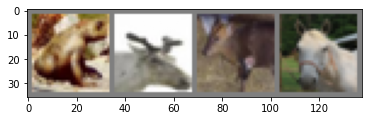

frog  deer  deer  horse


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Define a Convolutional Neural Network that can handle 3-channel images

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        """
        the forward function gets run whenever there is a call to a Net() object
        input: x (an image)
        output: a 
        """
        x_1 = self.pool(F.relu(self.conv1(x)))
        x_2 = self.pool(F.relu(self.conv2(x_1)))
        x_3 = torch.flatten(x_2, 1) # flatten all dimensions except batch
        x_4 = F.relu(self.fc1(x_3))
        x_5 = F.relu(self.fc2(x_4))
        x_6 = self.fc3(x_5)
        return x_6


net = Net()

Define a Loss function and optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Move data, model, loss and optimizer to GPU if available (in colab, you can use a GPU by going to Runtime -> Change Runtime Type -> GPU)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

net = net.to(device)
criterion = criterion.to(device)

Using cuda device


We simply have to loop over our data iterator, and feed the inputs to the network and optimize. Here, we train for 2 epochs, meaning the model sees all the training data twice.

In [ ]:
verbose=True
n_epochs = 2

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device) #move to GPU if available
        labels = labels.to(device) #move to GPU if available

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # track and print statistics
        # keep track of ncorrect
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        
        running_loss += loss.item()
        if(verbose):
            if i % 2000 == 1999:    # print training loss every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / i:.3f}')

    # avg training loss for the epoch
    print(f'===Epoch {epoch + 1} training loss: {running_loss / len(trainset):.3f}===')
    print(f'===Epoch {epoch + 1} training accuracy: {correct / len(trainset):.3f}===')

    if(True): #if true, calculate val set metrics after each epoch
        with torch.no_grad():
            running_val_loss = 0.0
            correct_val = 0
            for data in valloader:
                images, labels = data
                images = images.to(device) #move to GPU if available
                labels = labels.to(device) #move to GPU if available
                # calculate outputs by running images through the network
                outputs = net(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()
                running_val_loss += criterion(outputs, labels).item()
            print(f'===Epoch {epoch + 1} val loss: {running_val_loss / len(valset):.3f}===')
            print(f'===Epoch {epoch + 1} val accuracy: {correct_val /  len(valset):.3f}===')

print('Finished Training')

[1,  2000] loss: 2.276
[1,  4000] loss: 2.080
[1,  6000] loss: 1.953
[1,  8000] loss: 1.867
[1, 10000] loss: 1.801
===Epoch 1 training loss: 0.450===
===Epoch 1 training accuracy: 0.335===
===Epoch 1 val loss: 0.372===
===Epoch 1 val accuracy: 0.455===
[2,  2000] loss: 1.477
[2,  4000] loss: 1.455
[2,  6000] loss: 1.438
[2,  8000] loss: 1.420
[2, 10000] loss: 1.403
===Epoch 2 training loss: 0.351===
===Epoch 2 training accuracy: 0.496===
===Epoch 2 val loss: 0.344===
===Epoch 2 val accuracy: 0.514===
Finished Training


save the trained model (in colab, this will get deleted when your runtime is disconnected)

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
# # to load saved model
# net = Net()
# PATH = './cifar_net.pth'
# net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

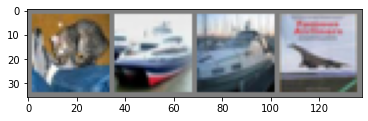

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:

In [ ]:
outputs = net(images.to(device))

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:


In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


Let us look at how the network performs on the whole dataset.

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device) #move to GPU if available
        labels = labels.to(device) #move to GPU if available
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 51 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device) #move to GPU if available
        labels = labels.to(device) #move to GPU if available
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f371371be50><function _MultiProcessingDataLoaderIter.__del__ at 0x7f371371be50>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
AssertionError
assert self._parent_pid == os.getpid(), 'can only test a child process':     can only test a child process
    self._shutdown_workers()  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers

    if w.is_alive():
  File "/usr/lib/pytho

Accuracy for class: plane is 41.2 %
Accuracy for class: car   is 76.3 %
Accuracy for class: bird  is 43.8 %
Accuracy for class: cat   is 27.6 %
Accuracy for class: deer  is 28.8 %
Accuracy for class: dog   is 40.9 %
Accuracy for class: frog  is 61.9 %
Accuracy for class: horse is 54.8 %
Accuracy for class: ship  is 79.2 %
Accuracy for class: truck is 57.1 %
